In [23]:
# Data Preprocessing Section

import torch
import numpy as np
import pandas as pd
from typing import List, Dict, Tuple
from pathlib import Path
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from datetime import datetime
import logging
from tqdm import tqdm
import warnings
import pickle  # Add this import


# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Suppress sklearn warnings
warnings.filterwarnings("ignore", category=UserWarning)

# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
logging.info(f"Using device: {device}")

class EHRDataPreprocessor:
    def __init__(self, data_path: str, feature_files: List[str], demographic_file: str, max_seq_length: int):
        self.data_path = Path(data_path)
        self.feature_files = feature_files
        self.demographic_file = demographic_file
        self.max_seq_length = max_seq_length
        self.data_types = self._get_data_types()
        self.data_type_to_idx = {dt: idx for idx, dt in enumerate(self.data_types)}
        self.value_normalizer = ValueNormalizer()
        self.reference_date = datetime(2000, 1, 1)
        self.continuous_features = ['hba1c', 'sbp', 'bmi', 'creat']
        self.categorical_features = []

    def _get_data_types(self) -> List[str]:
        return [file.split('.')[0] for file in self.feature_files] + ['demographics']

    def load_and_preprocess_data(self) -> Dict[int, Dict[str, torch.Tensor]]:
        feature_data = self._load_feature_data()
        demographic_data = self._load_demographic_data()
        
        logging.info("Fitting normalizers...")
        self.value_normalizer.fit(feature_data, demographic_data)
        
        logging.info("Preprocessing data...")
        preprocessed_data = {}
        for patient_id in tqdm(feature_data.keys(), desc="Processing patients"):
            patient_feature_data = feature_data[patient_id]
            patient_demographic_data = demographic_data.get(patient_id, {})
            try:
                preprocessed_data[patient_id] = self.preprocess_patient_data(patient_id, patient_feature_data, patient_demographic_data)
            except Exception as e:
                logging.error(f"Error processing patient {patient_id}: {str(e)}")
        
        return preprocessed_data

    def _load_feature_data(self) -> Dict[int, List[Tuple[str, float, float]]]:
        feature_data = {}
        for file in self.feature_files:
            df = pd.read_csv(self.data_path / file)
            feature_name = file.split('.')[0]
            for _, row in df.iterrows():
                patient_id = int(row['patient_id'])
                if patient_id not in feature_data:
                    feature_data[patient_id] = []
                timestamp = (datetime.strptime(row['timestamp'], '%Y-%m-%d') - self.reference_date).days
                value = row['value'] if pd.notna(row['value']) else None
                feature_data[patient_id].append((feature_name, value, float(timestamp)))
        return feature_data

    def _load_demographic_data(self) -> Dict[int, Dict[str, str]]:
        df = pd.read_csv(self.data_path / self.demographic_file)
        return {int(row['patient_id']): {col: str(row[col]) for col in df.columns if col != 'patient_id'} for _, row in df.iterrows()}

    def preprocess_patient_data(self, patient_id: int, feature_data: List[Tuple[str, float, float]], demographic_data: Dict[str, str]) -> Dict[str, torch.Tensor]:
        feature_data.sort(key=lambda x: x[2])
        seq_length = min(len(feature_data) + 1, self.max_seq_length)
        data_type_tensor = torch.zeros(seq_length, dtype=torch.long)
        value_tensor = torch.zeros(seq_length)
        time_tensor = torch.zeros(seq_length)
        mask_tensor = torch.zeros(seq_length, dtype=torch.bool)
        missing_tensor = torch.zeros(seq_length, dtype=torch.bool)

        for i, (data_type, value, timestamp) in enumerate(feature_data[:seq_length - 1]):
            data_type_tensor[i] = self.data_type_to_idx[data_type]
            if value is not None:
                value_tensor[i] = self.value_normalizer.normalize(data_type, value)
                mask_tensor[i] = True
            else:
                missing_tensor[i] = True
            time_tensor[i] = timestamp

        demo_idx = seq_length - 1
        data_type_tensor[demo_idx] = self.data_type_to_idx['demographics']
        value_tensor[demo_idx] = self.value_normalizer.normalize_demographics(demographic_data)
        time_tensor[demo_idx] = time_tensor[demo_idx - 1] if demo_idx > 0 else 0
        mask_tensor[demo_idx] = True

        time_diff_tensor = torch.zeros_like(time_tensor)
        time_diff_tensor[1:] = time_tensor[1:] - time_tensor[:-1]

        # Move tensors to GPU
        return {
            'patient_id': patient_id,
            'data_type': data_type_tensor,
            'value': value_tensor,
            'timestamp': time_tensor,
            'time_diff': time_diff_tensor,
            'mask': mask_tensor,
            'missing': missing_tensor
        }


class ValueNormalizer:
    def __init__(self):
        self.feature_scalers = {}
        self.demographic_encoder = None
        self.demographic_scaler = None
        self.reference_date = datetime(2000, 1, 1)
        self.demographic_columns = []
        self.data_type_to_idx = {}  # Add this line
        self.idx_to_data_type = {}  # Add this line

    def fit(self, feature_data: Dict[int, List[Tuple[str, float, float]]], demographic_data: Dict[int, Dict[str, str]]):
        feature_values = {feature: [] for feature in set(data_type for patient in feature_data.values() for data_type, _, _ in patient)}
        for patient_data in feature_data.values():
            for data_type, value, _ in patient_data:
                if value is not None:
                    feature_values[data_type].append(value)
        
        for feature, values in feature_values.items():
            self.feature_scalers[feature] = StandardScaler().fit(np.array(values).reshape(-1, 1))

        demographic_df = pd.DataFrame(demographic_data).T
        self.demographic_columns = demographic_df.columns.tolist()

        demographic_df['age'] = (pd.to_datetime(demographic_df['DOB'], errors='coerce') - self.reference_date).dt.days / 365.25
        demographic_df['years_since_diagnosis'] = (pd.to_datetime(demographic_df['date_diagnosis'], errors='coerce') - self.reference_date).dt.days / 365.25
        
        categorical_columns = ['dm_type', 'sex', 'ethCode']
        
        self.demographic_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
        self.demographic_encoder.fit(demographic_df[categorical_columns])
        
        numerical_columns = ['age', 'years_since_diagnosis']
        self.demographic_scaler = StandardScaler().fit(demographic_df[numerical_columns].fillna(0))
        
        # Create bidirectional mappings
        self.data_type_to_idx = {data_type: idx for idx, data_type in enumerate(self.feature_scalers.keys())}
        self.idx_to_data_type = {idx: data_type for data_type, idx in self.data_type_to_idx.items()}

    def normalize(self, data_type: str, value: float) -> float:
        if data_type in self.feature_scalers:
            return self.feature_scalers[data_type].transform([[value]])[0][0]
        else:
            return value
        
    def inverse_normalize(self, data_type: str, value: float) -> float:
        if data_type in self.feature_scalers:
            return self.feature_scalers[data_type].inverse_transform([[value]])[0][0]
        else:
            return value

    def normalize_demographics(self, demographic_data: Dict[str, str]) -> float:
        try:
            dob = pd.to_datetime(demographic_data.get('DOB', '2000-01-01'), errors='coerce')
            diagnosis_date = pd.to_datetime(demographic_data.get('date_diagnosis', '2000-01-01'), errors='coerce')
            
            age = (self.reference_date - dob).days / 365.25 if pd.notnull(dob) else 0
            years_since_diagnosis = (self.reference_date - diagnosis_date).days / 365.25 if pd.notnull(diagnosis_date) else 0
            
            categorical_data = [
                demographic_data.get('dm_type', 'Unknown'),
                demographic_data.get('sex', 'Unknown'),
                demographic_data.get('ethCode', 'Unknown')
            ]
            
            encoded_categorical = self.demographic_encoder.transform([categorical_data])
            scaled_numerical = self.demographic_scaler.transform([[age, years_since_diagnosis]])
            
            all_features = np.concatenate([encoded_categorical.flatten(), scaled_numerical.flatten()])
            
            return float(np.mean(all_features))
        except Exception as e:
            logging.error(f"Error in normalize_demographics: {str(e)}")
            logging.error(f"Demographic data: {demographic_data}")
            return 0.0
        
    def inverse_normalize(self, data_type: str, value: float) -> float:
        if data_type in self.feature_scalers:
            return self.feature_scalers[data_type].inverse_transform([[value]])[0][0]
        else:
            return value

# Example usage
data_path = "./processed_data"
feature_files = ["hba1c.csv", "sbp.csv", "bmi.csv", "creat.csv"]
demographic_file = "demographics.csv"
max_seq_length = 40

preprocessed_data_file = 'preprocessed_data.pkl'

if Path(preprocessed_data_file).exists():
    logging.info(f"Loading preprocessed data from {preprocessed_data_file}")
    with open(preprocessed_data_file, 'rb') as f:
        preprocessed_data = pickle.load(f)
else:
    logging.info("Preprocessing data...")
    preprocessor = EHRDataPreprocessor(data_path, feature_files, demographic_file, max_seq_length)
    preprocessed_data = preprocessor.load_and_preprocess_data()
    
    logging.info(f"Saving preprocessed data to {preprocessed_data_file}")
    with open(preprocessed_data_file, 'wb') as f:
        pickle.dump(preprocessed_data, f)
        

2024-10-14 21:37:22,596 - INFO - Using device: cuda
2024-10-14 21:37:22,598 - INFO - Loading preprocessed data from preprocessed_data.pkl


In [24]:
print(torch.cuda.is_available())
print(torch.cuda.device_count())
print(torch.cuda.current_device())
print(torch.cuda.device(0))
print(torch.cuda.get_device_name(0))

True
1
0
NVIDIA GeForce RTX 3090 Ti


In [25]:
import torch
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Sampler
import random

class EHRDataset(Dataset):
    def __init__(self, preprocessed_data):
        self.data = list(preprocessed_data.values())

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

def collate_fn(batch):
    batch = sorted(batch, key=lambda x: len(x['data_type']), reverse=True)
    
    lengths = [len(item['data_type']) for item in batch]
    max_len = max(lengths)

    padded_batch = {
        'patient_id': torch.tensor([item['patient_id'] for item in batch]),
        'data_type': pad_sequence([item['data_type'] for item in batch], batch_first=True, padding_value=0),
        'value': pad_sequence([item['value'] for item in batch], batch_first=True, padding_value=0.0),
        'timestamp': pad_sequence([item['timestamp'] for item in batch], batch_first=True, padding_value=0.0),
        'time_diff': pad_sequence([item['time_diff'] for item in batch], batch_first=True, padding_value=0.0),
        'mask': pad_sequence([item['mask'] for item in batch], batch_first=True, padding_value=False),
        'missing': pad_sequence([item['missing'] for item in batch], batch_first=True, padding_value=True)
    }

    attention_mask = torch.zeros(len(batch), max_len, dtype=torch.bool)
    for i, length in enumerate(lengths):
        attention_mask[i, :length] = 1

    padded_batch['attention_mask'] = attention_mask
    padded_batch['lengths'] = torch.tensor(lengths)

    return padded_batch  # Return CPU tensors

class PatientSampler(Sampler):
    def __init__(self, dataset, batch_size, drop_last=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.drop_last = drop_last
        self.patient_to_indices = self._create_patient_to_indices()

    def _create_patient_to_indices(self):
        patient_to_indices = {}
        for idx, item in enumerate(self.dataset.data):
            patient_id = item['patient_id']
            if patient_id not in patient_to_indices:
                patient_to_indices[patient_id] = []
            patient_to_indices[patient_id].append(idx)
        return patient_to_indices

    def __iter__(self):
        batches = []
        patients = list(self.patient_to_indices.keys())
        random.shuffle(patients)
        
        current_batch = []
        for patient in patients:
            indices = self.patient_to_indices[patient]
            if len(indices) >= 2:
                # Add two instances of the same patient to ensure positive pairs
                current_batch.extend(random.sample(indices, 2))
            elif len(indices) == 1:
                # If only one instance, add it twice
                current_batch.extend(indices * 2)
            
            if len(current_batch) >= self.batch_size:
                batches.append(current_batch[:self.batch_size])
                current_batch = current_batch[self.batch_size:]
        
        if not self.drop_last and current_batch:
            batches.append(current_batch)
        
        random.shuffle(batches)
        return iter(batches)

    def __len__(self):
        if self.drop_last:
            return len(self.dataset) // self.batch_size
        else:
            return (len(self.dataset) + self.batch_size - 1) // self.batch_size


# Create the dataset
dataset = EHRDataset(preprocessed_data)

# Create the patient sampler
patient_sampler = PatientSampler(dataset, batch_size=2)

# Create the dataloader
dataloader = DataLoader(dataset, batch_size=32, shuffle=True, collate_fn=collate_fn, pin_memory=True)


# Verify that patient_id is included in the batch
for batch in dataloader:
    print("Keys in batch:", batch.keys())
    print("Patient IDs shape:", batch['patient_id'].shape)
    break  # Just check the first batch

Keys in batch: dict_keys(['patient_id', 'data_type', 'value', 'timestamp', 'time_diff', 'mask', 'missing', 'attention_mask', 'lengths'])
Patient IDs shape: torch.Size([32])


In [26]:
# Model Architecture Section

import torch
import torch.nn as nn
import torch.nn.functional as F
import math

class TimeAwareMultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super().__init__()
        assert d_model % num_heads == 0, "d_model must be divisible by num_heads"
        
        self.d_model = d_model
        self.num_heads = num_heads
        self.d_k = d_model // num_heads
        
        self.W_q = nn.Linear(d_model, d_model)
        self.W_k = nn.Linear(d_model, d_model)
        self.W_v = nn.Linear(d_model, d_model)
        self.W_o = nn.Linear(d_model, d_model)
        
    def forward(self, query, key, value, time_diff, mask=None):
        batch_size = query.size(0)
        seq_length = query.size(1)
        
        Q = self.W_q(query)
        K = self.W_k(key)
        V = self.W_v(value)
        
        Q = Q.view(batch_size, seq_length, self.num_heads, self.d_k).transpose(1, 2)
        K = K.view(batch_size, seq_length, self.num_heads, self.d_k).transpose(1, 2)
        V = V.view(batch_size, seq_length, self.num_heads, self.d_k).transpose(1, 2)
        
        time_diff = time_diff.unsqueeze(1).unsqueeze(1)  # [batch_size, 1, 1, seq_length]
        time_diff = time_diff.expand(-1, self.num_heads, seq_length, -1)  # [batch_size, num_heads, seq_length, seq_length]
        time_diff = torch.abs(time_diff.transpose(-1, -2) - time_diff)
        
        scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.d_k)
        time_impact = torch.exp(-time_diff.clamp(min=-100, max=100))
        scores = scores * time_impact
        
        if mask is not None:
            scores = scores.masked_fill(~mask.unsqueeze(1).unsqueeze(2), float('-inf'))
        
        attn = F.softmax(scores, dim=-1)
        attn = torch.nan_to_num(attn, 0.0, 0.0, 0.0)  # Replace NaNs with zeros
        context = torch.matmul(attn, V)
        
        context = context.transpose(1, 2).contiguous().view(batch_size, seq_length, self.d_model)
        output = self.W_o(context)
        
        return output

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        self.dropout = nn.Dropout(p=0.1)
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x, timestamps):
        x = x + self.pe[:x.size(0), :]
        # print(f"In PositionalEncoding, x shape: {x.shape}, min: {x.min().item()}, max: {x.max().item()}")
        return self.dropout(x)

class TransformerEncoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout=0.1):
        super().__init__()
        self.self_attn = TimeAwareMultiHeadAttention(d_model, num_heads)
        self.feed_forward = nn.Sequential(
            nn.Linear(d_model, d_ff),
            nn.ReLU(),
            nn.Linear(d_ff, d_model)
        )
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x, time_diff, mask=None):
        # Apply layer norm before self-attention
        x_norm = self.norm1(x)
        
        attn_output = self.self_attn(x_norm, x_norm, x_norm, time_diff, mask)
        # print(f"After self-attention, output shape: {attn_output.shape}, min: {attn_output.min().item()}, max: {attn_output.max().item()}")
        
        # Add residual connection
        x = x + self.dropout(attn_output)
        x = torch.nan_to_num(x, 0.0, 0.0, 0.0)  # Replace NaNs with zeros
        # print(f"After residual connection, x shape: {x.shape}, min: {x.min().item()}, max: {x.max().item()}")
        
        # Apply layer norm before feed-forward
        x_norm = self.norm2(x)
        ff_output = self.feed_forward(x_norm)
        # print(f"After feed-forward, output shape: {ff_output.shape}, min: {ff_output.min().item()}, max: {ff_output.max().item()}")
        
        # Add residual connection
        x = x + self.dropout(ff_output)
        x = torch.nan_to_num(x, 0.0, 0.0, 0.0)  # Replace NaNs with zeros
        # print(f"After second residual connection, x shape: {x.shape}, min: {x.min().item()}, max: {x.max().item()}")
        
        return x

# Model definition
class EHRTransformer(nn.Module):
    def __init__(self, num_data_types, d_model, num_heads, num_layers, d_ff, dropout):
        super().__init__()
        self.data_type_embedding = nn.Embedding(num_data_types, d_model)
        self.value_embedding = nn.Linear(1, d_model)
        self.positional_encoding = PositionalEncoding(d_model)
        
        self.transformer_layers = nn.ModuleList([
            TransformerEncoderLayer(d_model, num_heads, d_ff, dropout)
            for _ in range(num_layers)
        ])
        
        self.output_layer = nn.Linear(d_model, d_model)
        self.layer_norm = nn.LayerNorm(d_model)
        
    def forward(self, data_type, value, timestamp, time_diff, attention_mask):
        # Embedding layers
        data_type_emb = self.data_type_embedding(data_type)
        value_emb = self.value_embedding(value.unsqueeze(-1))
        
        # Combine embeddings
        x = data_type_emb + value_emb
        x = torch.clamp(x, min=-100, max=100)  # Prevent extreme values
        
        # Add positional encoding using timestamps
        x = self.positional_encoding(x, timestamp)
        x = torch.clamp(x, min=-100, max=100)  # Prevent extreme values
        
        # Apply transformer layers
        for layer in self.transformer_layers:
            x = layer(x, time_diff, attention_mask)
            x = torch.clamp(x, min=-100, max=100)  # Prevent extreme values
            x = torch.nan_to_num(x, 0.0, 0.0, 0.0)  # Replace NaNs with zeros
        
        # Output layer with layer normalization
        output = self.layer_norm(self.output_layer(x))
        output = torch.clamp(output, min=-100, max=100)  # Prevent extreme values
        output = torch.nan_to_num(output, 0.0, 0.0, 0.0)  # Replace NaNs with zeros
        
        return output
        pass
    

# Example usage
num_data_types = 100  # Adjust based on your data
d_model = 256
num_heads = 16
num_layers = 6
d_ff = 512
dropout = 0.4

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")
print(f"Using device: {device}")

# Create the model and move it to the device
model = EHRTransformer(num_data_types, d_model, num_heads, num_layers, d_ff, dropout).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# Create the dataset and dataloader
dataset = EHRDataset(preprocessed_data)
dataloader = DataLoader(dataset, batch_size=512, shuffle=True, collate_fn=collate_fn, pin_memory=True)

# Test the model with a batch
for batch in dataloader:
    # Move the entire batch to the device
    batch = {k: v.to(device) for k, v in batch.items()}
    
    # Print the shape of the mask before passing it to the model
    print(f"Mask shape: {batch['mask'].shape}")
    
    output = model(batch['data_type'], batch['value'], batch['timestamp'], batch['time_diff'], batch['mask'])
    print(f"Output shape: {output.shape}")
    break  # Just to check the first batch

Using device: cuda
Mask shape: torch.Size([512, 40])
Output shape: torch.Size([512, 40, 128])


In [36]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm
import random
import json
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F

class MaskedReconstructionLoss(nn.Module):
    def __init__(self, continuous_features, num_categories):
        super().__init__()
        self.mse_loss = nn.MSELoss(reduction='none')
        self.ce_loss = nn.CrossEntropyLoss(reduction='none', ignore_index=-1)
        self.continuous_features = continuous_features
        self.num_categories = num_categories

    def forward(self, predictions, targets, data_type, mask_indices, attention_mask):
        active_loss = (attention_mask.view(-1) == 1) & (mask_indices.view(-1) == 1)
        active_preds = predictions.view(-1, predictions.size(-1))[active_loss]
        active_targets = targets.view(-1)[active_loss]
        active_data_type = data_type.view(-1)[active_loss]

        cont_mask = torch.tensor([dt in self.continuous_features for dt in active_data_type])
        cat_mask = ~cont_mask

        total_loss = 0
        num_samples = active_loss.sum()

        if cont_mask.any():
            cont_preds = active_preds[cont_mask, 0]
            cont_targets = active_targets[cont_mask]
            cont_loss = self.mse_loss(cont_preds, cont_targets).mean()
            total_loss += cont_loss
            # print(f"Continuous Loss: {cont_loss.item():.4f}")
            # print(f"Continuous Preds min/max: {cont_preds.min().item():.4f}/{cont_preds.max().item():.4f}")
            # print(f"Continuous Targets min/max: {cont_targets.min().item():.4f}/{cont_targets.max().item():.4f}")

        if cat_mask.any():
            cat_preds = active_preds[cat_mask]
            cat_targets = active_targets[cat_mask].long()
            cat_targets = torch.clamp(cat_targets, min=0, max=self.num_categories-1)
            cat_loss = self.ce_loss(cat_preds, cat_targets).mean()
            total_loss += cat_loss
            # print(f"Categorical Loss: {cat_loss.item():.4f}")
            # print(f"Categorical Preds min/max: {cat_preds.min().item():.4f}/{cat_preds.max().item():.4f}")
            # print(f"Categorical Targets min/max: {cat_targets.min().item()}/{cat_targets.max().item()}")

        return total_loss

class ContrastiveLoss(nn.Module):
    def __init__(self, temperature=0.5):
        super().__init__()
        self.temperature = temperature

    def forward(self, embeddings, patient_ids):
        if torch.isnan(embeddings).any():
            print("NaN detected in embeddings!")
            return torch.tensor(0.0, requires_grad=True)

        embeddings = F.normalize(embeddings, p=2, dim=1)
        
        sim_matrix = torch.matmul(embeddings, embeddings.T) / self.temperature
        
        pos_mask = (patient_ids.unsqueeze(0) == patient_ids.unsqueeze(1)).float()
        pos_mask.fill_diagonal_(0)
        
        if pos_mask.sum() == 0:
            print("No positive pairs found in the batch!")
            return torch.tensor(0.0, requires_grad=True)

        neg_mask = 1 - pos_mask
        neg_mask.fill_diagonal_(0)

        pos_sim = torch.exp(sim_matrix) * pos_mask
        neg_sim = torch.exp(sim_matrix) * neg_mask

        loss = -torch.log(pos_sim.sum(dim=1) / (pos_sim.sum(dim=1) + neg_sim.sum(dim=1) + 1e-8))
        return loss.mean()
        

def mask_data(data, mask, mask_ratio=0.15):
    mask_indices = torch.rand_like(data.float()) < mask_ratio
    mask_indices = mask_indices & mask
    masked_data = data.clone()
    masked_data[mask_indices] = 0
    return masked_data, mask_indices

def train_epoch(model, dataloader, optimizer, continuous_features, num_categories, device, mask_ratio=0.15, clip_value=1.0):
    model.train()
    total_loss = 0
    reconstruction_loss_fn = MaskedReconstructionLoss(continuous_features, num_categories).to(device)
    contrastive_loss_fn = ContrastiveLoss().to(device)
    
    epoch_losses = {
        'total': [],
        'reconstruction': [],
        'contrastive': []
    }

    for batch_idx, batch in enumerate(tqdm(dataloader, desc="Training")):
        optimizer.zero_grad()

        # Move individual tensors to device
        data_type = batch['data_type'].to(device)
        value = batch['value'].to(device)
        timestamp = batch['timestamp'].to(device)
        time_diff = batch['time_diff'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        patient_ids = batch['patient_id'].to(device)

        masked_value, mask_indices = mask_data(value, attention_mask, mask_ratio)
        mask_indices = mask_indices.to(device)

        try:
            output = model(data_type, masked_value, timestamp, time_diff, attention_mask)
            
            if torch.isnan(output).any():
                print(f"NaN detected in model output at batch {batch_idx}")
                print(f"Input shapes: data_type {data_type.shape}, masked_value {masked_value.shape}, timestamp {timestamp.shape}, time_diff {time_diff.shape}, attention_mask {attention_mask.shape}")
                print(f"Output shape: {output.shape}")
                print(f"Output min/max: {output.min().item()}/{output.max().item()}")
                continue

            recon_loss = reconstruction_loss_fn(output, value, data_type, mask_indices, attention_mask)
            
            mean_embedding = (output * attention_mask.unsqueeze(-1)).sum(dim=1) / (attention_mask.sum(dim=1, keepdim=True) + 1e-8)
            contrastive_loss = contrastive_loss_fn(mean_embedding, patient_ids)

            contrastive_weight = 0.1
            loss = recon_loss + contrastive_weight * contrastive_loss

            if not torch.isnan(loss) and not torch.isinf(loss):
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), clip_value)
                optimizer.step()

                total_loss += loss.item()
                epoch_losses['total'].append(loss.item())
                epoch_losses['reconstruction'].append(recon_loss.item())
                epoch_losses['contrastive'].append(contrastive_loss.item())

            # if batch_idx % 10 == 0:
                # print(f"Batch {batch_idx} losses - Total: {loss.item():.4f}, Recon: {recon_loss.item():.4f}, Contrastive: {contrastive_loss.item():.4f}")
                #print(f"Unique patient IDs in batch: {patient_ids.unique().shape[0]}")
                #print(f"Patient ID counts: {torch.bincount(patient_ids)}")

        except Exception as e:
            print(f"Error in batch {batch_idx}: {str(e)}")
            print("Batch keys:", batch.keys())
            for key, value in batch.items():
                print(f"{key} shape: {value.shape}")
            continue

    return total_loss / len(dataloader), epoch_losses

# In the main training loop
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)  # Reduced learning rate

def train_model(model, dataloader, num_epochs, learning_rate, device, continuous_features, num_categories):
    model = model.to(device)
    print(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    
    value_normalizer = ValueNormalizer()  # Make sure to initialize and fit this properly
    value_normalizer.fit(feature_data, demographic_data)  # You need to do this before training
    
    all_losses = []
    
    torch.cuda.synchronize()

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        for batch in tqdm(dataloader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            batch = {k: v.to(device) for k, v in batch.items() if isinstance(v, torch.Tensor)}
            optimizer.zero_grad()
            
            # Forward pass
            output = model(batch['data_type'], batch['value'], batch['timestamp'], batch['time_diff'], batch['mask'])
            
            # Compute loss (you need to define your loss function)
            loss = compute_loss(output, batch)
            
            # Backward pass
            loss.backward()
            
            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            optimizer.step()
            
            total_loss += loss.item()
            
            # Clear cache
            torch.cuda.empty_cache()
            
        avg_loss = total_loss / len(dataloader)
        logging.info(f"Epoch {epoch+1}/{num_epochs}, Average Loss: {avg_loss:.4f}")
        
        # Visualize reconstructions
        if epoch % 5 == 0:
            reconstruct_and_compare_features(model, dataloader, device, value_normalizer)

        # Save model checkpoint
        torch.save(model.state_dict(), f"model_checkpoint_epoch_{epoch+1}.pth")
        
    # Final model save
    torch.save(model.state_dict(), "final_model.pth")
            
    
    # Save losses to file
    with open('training_losses.json', 'w') as f:
        json.dump(all_losses, f)
    print("Loss data saved to 'training_losses.json'")
    
    # Plot losses
    plot_losses(all_losses)

    return model, all_losses

def plot_losses(all_losses):
    epochs = range(1, len(all_losses) + 1)
    
    plt.figure(figsize=(12, 8))
    
    # Total Loss
    total_losses = [np.mean(epoch['total']) for epoch in all_losses]
    plt.plot(epochs, total_losses, label='Total Loss', marker='o')
    print('total_losses:' + str(total_losses))
    
    # Reconstruction Loss
    recon_losses = [np.mean(epoch['reconstruction']) for epoch in all_losses]
    plt.plot(epochs, recon_losses, label='Reconstruction Loss', marker='s')
    print('recon_losses:' + str(recon_losses))
    
    # Contrastive Loss
    contrastive_losses = [np.mean(epoch['contrastive']) for epoch in all_losses]
    plt.plot(epochs, contrastive_losses, label='Contrastive Loss', marker='^')
    print('contrastive_losses:' + str(contrastive_losses))
    plt.title('Training Losses over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    
    # Save the plot
    plt.savefig('training_losses.png')
    print("Loss plot saved as 'training_losses.png'")
    
    # Display the plot (if running in an interactive environment)
    plt.show()
    
    # Close the plot to free up memory
    plt.close()

# Example usage
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_epochs = 8
learning_rate = 1e-4
continuous_features = ['hba1c', 'sbp', 'bmi', 'creat']  # Update this list based on your data
num_categories = 40  # Set this to the number of categories in your categorical variables

# model, losses = train_model(model, dataloader, num_epochs, learning_rate, device, continuous_features, num_categories)

cuda


Training: 7318it [01:29, 81.38it/s]                          


Epoch 1/200, Loss: 1.4213


Training: 7318it [01:30, 81.15it/s]                          


Epoch 2/200, Loss: 1.0979


Training: 7318it [01:29, 81.35it/s]                          


Epoch 3/200, Loss: 1.0579


Training: 7318it [01:29, 81.45it/s]                          


Epoch 4/200, Loss: 1.0394


Training: 7318it [01:30, 80.82it/s]                          


Epoch 5/200, Loss: 1.0278


Training: 7318it [01:30, 81.00it/s]                          


Epoch 6/200, Loss: 1.0143


Training: 7318it [01:29, 81.55it/s]                          


Epoch 7/200, Loss: 0.9976


Training: 7318it [01:29, 81.48it/s]                          


Epoch 8/200, Loss: 0.9830


Training: 7318it [01:29, 81.53it/s]                          


Epoch 9/200, Loss: 0.9745


Training: 7318it [01:29, 81.51it/s]                          


Epoch 10/200, Loss: 0.9684


Training: 7318it [01:25, 85.49it/s]                          


Epoch 11/200, Loss: 0.9645


Training: 7318it [01:24, 86.16it/s]                          


Epoch 12/200, Loss: 0.9616


Training: 7318it [01:24, 86.29it/s]                          


Epoch 13/200, Loss: 0.9580


Training: 7318it [01:24, 86.71it/s]                          


Epoch 14/200, Loss: 0.9585


Training: 7318it [01:24, 86.50it/s]                          


Epoch 15/200, Loss: 0.9515


Training: 7318it [01:24, 86.48it/s]                          


Epoch 16/200, Loss: 0.9500


Training: 7318it [01:25, 85.74it/s]                          


Epoch 17/200, Loss: 0.9501


Training: 7318it [01:25, 86.07it/s]                          


Epoch 18/200, Loss: 0.9491


Training: 7318it [01:24, 86.50it/s]                          


Epoch 19/200, Loss: 0.9473


Training: 7318it [01:24, 86.53it/s]                          


Epoch 20/200, Loss: 0.9466


Training: 7318it [01:24, 86.68it/s]                          


Epoch 21/200, Loss: 0.9448


Training: 7318it [01:24, 86.25it/s]                          


Epoch 22/200, Loss: 0.9451


Training: 7318it [01:24, 86.47it/s]                          


Epoch 23/200, Loss: 0.9391


Training: 7318it [01:24, 86.15it/s]                          


Epoch 24/200, Loss: 0.9408


Training: 7318it [01:24, 86.23it/s]                          


Epoch 25/200, Loss: 0.9384


Training: 7318it [01:24, 86.59it/s]                          


Epoch 26/200, Loss: 0.9401


Training: 7318it [01:25, 85.72it/s]                          


Epoch 27/200, Loss: 0.9355


Training: 7318it [01:24, 86.72it/s]                          


Epoch 28/200, Loss: 0.9372


Training: 7318it [01:24, 86.20it/s]                          


Epoch 29/200, Loss: 0.9351


Training: 7318it [01:25, 85.98it/s]                          


Epoch 30/200, Loss: 0.9343


Training: 7318it [01:24, 86.11it/s]                          


Epoch 31/200, Loss: 0.9335


Training: 7318it [01:24, 86.55it/s]                          


Epoch 32/200, Loss: 0.9354


Training: 7318it [01:24, 86.82it/s]                          


Epoch 33/200, Loss: 0.9353


Training: 7318it [01:24, 86.73it/s]                          


Epoch 34/200, Loss: 0.9325


Training: 7318it [01:24, 86.19it/s]                          


Epoch 35/200, Loss: 0.9316


Training: 7318it [01:24, 86.35it/s]                          


Epoch 36/200, Loss: 0.9320


Training: 7318it [01:24, 87.05it/s]                          


Epoch 37/200, Loss: 0.9333


Training: 7318it [01:24, 86.17it/s]                          


Epoch 38/200, Loss: 0.9296


Training: 7318it [01:24, 86.11it/s]                          


Epoch 39/200, Loss: 0.9296


Training: 7318it [01:24, 86.22it/s]                          


Epoch 40/200, Loss: 0.9280


Training: 7318it [01:24, 86.66it/s]                          


Epoch 41/200, Loss: 0.9309


Training: 7318it [01:24, 86.75it/s]                          


Epoch 42/200, Loss: 0.9292


Training: 7318it [01:24, 86.12it/s]                          


Epoch 43/200, Loss: 0.9283


Training: 7318it [01:25, 85.67it/s]                          


Epoch 44/200, Loss: 0.9293


Training: 7318it [01:24, 86.16it/s]                          


Epoch 45/200, Loss: 0.9266


Training: 7318it [01:24, 86.38it/s]                          


Epoch 46/200, Loss: 0.9242


Training: 7318it [01:24, 86.20it/s]                          


Epoch 47/200, Loss: 0.9256


Training: 7318it [01:24, 86.20it/s]                          


Epoch 48/200, Loss: 0.9286


Training: 7318it [01:24, 86.77it/s]                          


Epoch 49/200, Loss: 0.9282


Training: 7318it [01:24, 86.27it/s]                          


Epoch 50/200, Loss: 0.9254


Training: 7318it [01:24, 86.40it/s]                          


Epoch 51/200, Loss: 0.9235


Training: 7318it [01:24, 86.41it/s]                          


Epoch 52/200, Loss: 0.9268


Training: 7318it [01:25, 85.65it/s]                          


Epoch 53/200, Loss: 0.9222


Training: 7318it [01:25, 85.98it/s]                          


Epoch 54/200, Loss: 0.9240


Training: 7318it [01:24, 86.52it/s]                          


Epoch 55/200, Loss: 0.9232


Training: 7318it [01:25, 86.03it/s]                          


Epoch 56/200, Loss: 0.9247


Training: 7318it [01:24, 86.31it/s]                          


Epoch 57/200, Loss: 0.9225


Training: 7318it [01:25, 85.94it/s]                          


Epoch 58/200, Loss: 0.9222


Training: 7318it [01:24, 86.24it/s]                          


Epoch 59/200, Loss: 0.9239


Training: 7318it [01:25, 85.84it/s]                          


Epoch 60/200, Loss: 0.9199


Training: 7318it [01:24, 86.26it/s]                          


Epoch 61/200, Loss: 0.9203


Training: 7318it [01:24, 86.48it/s]                          


Epoch 62/200, Loss: 0.9217


Training: 7318it [01:24, 86.56it/s]                          


Epoch 63/200, Loss: 0.9221


Training: 7318it [01:24, 86.85it/s]                          


Epoch 64/200, Loss: 0.9192


Training: 7318it [01:23, 87.18it/s]                          


Epoch 65/200, Loss: 0.9218


Training: 7318it [01:25, 85.90it/s]                          


Epoch 66/200, Loss: 0.9211


Training: 7318it [01:24, 86.36it/s]                          


Epoch 67/200, Loss: 0.9201


Training: 7318it [01:25, 85.98it/s]                          


Epoch 68/200, Loss: 0.9211


Training: 7318it [01:24, 86.10it/s]                          


Epoch 69/200, Loss: 0.9209


Training: 7318it [01:25, 86.00it/s]                          


Epoch 70/200, Loss: 0.9176


Training: 7318it [01:24, 86.70it/s]                          


Epoch 71/200, Loss: 0.9209


Training: 7318it [01:24, 86.67it/s]                          


Epoch 72/200, Loss: 0.9183


Training: 7318it [01:24, 86.43it/s]                          


Epoch 73/200, Loss: 0.9184


Training: 7318it [01:25, 86.07it/s]                          


Epoch 74/200, Loss: 0.9185


Training: 7318it [01:24, 86.96it/s]                          


Epoch 75/200, Loss: 0.9188


Training: 7318it [01:24, 86.51it/s]                          


Epoch 76/200, Loss: 0.9178


Training: 7318it [01:24, 86.58it/s]                          


Epoch 77/200, Loss: 0.9203


Training: 7318it [01:24, 86.26it/s]                          


Epoch 78/200, Loss: 0.9179


Training: 7318it [01:24, 86.65it/s]                          


Epoch 79/200, Loss: 0.9170


Training: 7318it [01:25, 85.66it/s]                          


Epoch 80/200, Loss: 0.9173


Training: 7318it [01:25, 85.80it/s]                          


Epoch 81/200, Loss: 0.9144


Training: 7318it [01:24, 86.42it/s]                          


Epoch 82/200, Loss: 0.9161


Training: 7318it [01:25, 86.04it/s]                          


Epoch 83/200, Loss: 0.9151


Training: 7318it [01:24, 86.26it/s]                          


Epoch 84/200, Loss: 0.9168


Training: 7318it [01:25, 85.75it/s]                          


Epoch 85/200, Loss: 0.9150


Training: 7318it [01:24, 86.64it/s]                          


Epoch 86/200, Loss: 0.9148


Training: 7318it [01:25, 86.09it/s]                          


Epoch 87/200, Loss: 0.9136


Training: 7318it [01:25, 85.88it/s]                          


Epoch 88/200, Loss: 0.9147


Training: 7318it [01:24, 86.42it/s]                          


Epoch 89/200, Loss: 0.9130


Training: 7318it [01:24, 86.74it/s]                          


Epoch 90/200, Loss: 0.9121


Training: 7318it [01:24, 86.94it/s]                          


Epoch 91/200, Loss: 0.9122


Training: 7318it [01:24, 86.83it/s]                          


Epoch 92/200, Loss: 0.9122


Training: 7318it [01:24, 86.93it/s]                          


Epoch 93/200, Loss: 0.9105


Training: 7318it [01:24, 86.37it/s]                          


Epoch 94/200, Loss: 0.9120


Training: 7318it [01:24, 86.34it/s]                          


Epoch 95/200, Loss: 0.9097


Training: 7318it [01:24, 86.27it/s]                          


Epoch 96/200, Loss: 0.9100


Training: 7318it [01:24, 86.98it/s]                          


Epoch 97/200, Loss: 0.9089


Training: 7318it [01:24, 86.60it/s]                          


Epoch 98/200, Loss: 0.9089


Training: 7318it [01:24, 86.73it/s]                          


Epoch 99/200, Loss: 0.9084


Training: 7318it [01:24, 87.06it/s]                          


Epoch 100/200, Loss: 0.9077


Training: 7318it [01:24, 86.63it/s]                          


Epoch 101/200, Loss: 0.9070


Training: 7318it [01:24, 86.68it/s]                          


Epoch 102/200, Loss: 0.9059


Training: 7318it [01:25, 85.60it/s]                          


Epoch 103/200, Loss: 0.9051


Training: 7318it [01:25, 85.98it/s]                          


Epoch 104/200, Loss: 0.9067


Training: 7318it [01:24, 86.37it/s]                          


Epoch 105/200, Loss: 0.9051


Training: 7318it [01:24, 86.88it/s]                          


Epoch 106/200, Loss: 0.9052


Training: 7318it [01:24, 86.76it/s]                          


Epoch 107/200, Loss: 0.9051


Training: 7318it [01:24, 86.96it/s]                          


Epoch 108/200, Loss: 0.9037


Training: 7318it [01:25, 85.90it/s]                          


Epoch 109/200, Loss: 0.9030


Training: 7318it [01:24, 86.28it/s]                          


Epoch 110/200, Loss: 0.9026


Training: 7318it [01:24, 86.49it/s]                          


Epoch 111/200, Loss: 0.9010


Training: 7318it [01:24, 86.52it/s]                          


Epoch 112/200, Loss: 0.9011


Training: 7318it [01:24, 86.28it/s]                          


Epoch 113/200, Loss: 0.9019


Training: 7318it [01:24, 86.73it/s]                          


Epoch 114/200, Loss: 0.9027


Training: 7318it [01:24, 86.10it/s]                          


Epoch 115/200, Loss: 0.9003


Training: 7318it [01:24, 86.90it/s]                          


Epoch 116/200, Loss: 0.9009


Training: 7318it [01:24, 86.63it/s]                          


Epoch 117/200, Loss: 0.9017


Training: 7318it [01:24, 86.61it/s]                          


Epoch 118/200, Loss: 0.9001


Training: 7318it [01:25, 85.79it/s]                          


Epoch 119/200, Loss: 0.8980


Training: 7318it [01:25, 85.38it/s]                          


Epoch 120/200, Loss: 0.8993


Training: 7318it [01:24, 86.90it/s]                          


Epoch 121/200, Loss: 0.8994


Training: 7318it [01:25, 86.09it/s]                          


Epoch 122/200, Loss: 0.9000


Training: 7318it [01:24, 86.38it/s]                          


Epoch 123/200, Loss: 0.8964


Training: 7318it [01:23, 87.18it/s]                          


Epoch 124/200, Loss: 0.8995


Training: 7318it [01:24, 86.83it/s]                          


Epoch 125/200, Loss: 0.8960


Training: 7318it [01:24, 86.76it/s]                          


Epoch 126/200, Loss: 0.8959


Training: 7318it [01:24, 86.72it/s]                          


Epoch 127/200, Loss: 0.8954


Training: 7318it [01:24, 86.66it/s]                          


Epoch 128/200, Loss: 0.8940


Training: 7318it [01:24, 86.73it/s]                          


Epoch 129/200, Loss: 0.8955


Training: 7318it [01:24, 86.18it/s]                          


Epoch 130/200, Loss: 0.8950


Training: 7318it [01:24, 86.92it/s]                          


Epoch 131/200, Loss: 0.8960


Training: 7318it [01:24, 86.67it/s]                          


Epoch 132/200, Loss: 0.8942


Training: 7318it [01:24, 86.28it/s]                          


Epoch 133/200, Loss: 0.8920


Training: 7318it [01:24, 86.90it/s]                          


Epoch 134/200, Loss: 0.8955


Training: 7318it [01:23, 87.31it/s]                          


Epoch 135/200, Loss: 0.8942


Training: 7318it [01:25, 86.01it/s]                          


Epoch 136/200, Loss: 0.8940


Training: 7318it [01:24, 86.76it/s]                          


Epoch 137/200, Loss: 0.8919


Training: 7318it [01:24, 86.50it/s]                          


Epoch 138/200, Loss: 0.8910


Training: 7318it [01:24, 86.78it/s]                          


Epoch 139/200, Loss: 0.8909


Training: 7318it [01:24, 86.77it/s]                          


Epoch 140/200, Loss: 0.8919


Training: 7318it [01:24, 86.60it/s]                          


Epoch 141/200, Loss: 0.8921


Training: 7318it [01:25, 85.96it/s]                          


Epoch 142/200, Loss: 0.8911


Training: 7318it [01:24, 86.52it/s]                          


Epoch 143/200, Loss: 0.8881


Training: 7318it [01:25, 85.85it/s]                          


Epoch 144/200, Loss: 0.8882


Training: 7318it [01:24, 86.34it/s]                          


Epoch 145/200, Loss: 0.8876


Training: 7318it [01:24, 86.69it/s]                          


Epoch 146/200, Loss: 0.8894


Training: 7318it [01:24, 86.43it/s]                          


Epoch 147/200, Loss: 0.8873


Training: 7318it [01:24, 86.63it/s]                          


Epoch 148/200, Loss: 0.8857


Training: 7318it [01:24, 86.56it/s]                          


Epoch 149/200, Loss: 0.8867


Training: 7318it [01:25, 86.02it/s]                          


Epoch 150/200, Loss: 0.8866


Training: 7318it [01:25, 86.02it/s]                          


Epoch 151/200, Loss: 0.8867


Training: 7318it [01:24, 86.79it/s]                          


Epoch 152/200, Loss: 0.8884


Training: 7318it [01:25, 86.04it/s]                          


Epoch 153/200, Loss: 0.8868


Training: 7318it [01:24, 86.83it/s]                          


Epoch 154/200, Loss: 0.8829


Training: 7318it [01:24, 86.20it/s]                          


Epoch 155/200, Loss: 0.8856


Training: 7318it [01:24, 86.24it/s]                          


Epoch 156/200, Loss: 0.8848


Training: 7318it [01:24, 86.18it/s]                          


Epoch 157/200, Loss: 0.8831


Training: 7318it [01:24, 86.74it/s]                          


Epoch 158/200, Loss: 0.8831


Training: 7318it [01:25, 85.89it/s]                          


Epoch 159/200, Loss: 0.8821


Training: 7318it [01:25, 85.98it/s]                          


Epoch 160/200, Loss: 0.8842


Training: 7318it [01:25, 85.92it/s]                          


Epoch 161/200, Loss: 0.8807


Training: 7318it [01:24, 86.68it/s]                          


Epoch 162/200, Loss: 0.8817


Training: 7318it [01:24, 86.19it/s]                          


Epoch 163/200, Loss: 0.8827


Training: 7318it [01:24, 87.06it/s]                          


Epoch 164/200, Loss: 0.8803


Training: 7318it [01:24, 86.77it/s]                          


Epoch 165/200, Loss: 0.8827


Training: 7318it [01:24, 86.49it/s]                          


Epoch 166/200, Loss: 0.8783


Training: 7318it [01:24, 86.52it/s]                          


Epoch 167/200, Loss: 0.8814


Training: 7318it [01:24, 86.88it/s]                          


Epoch 168/200, Loss: 0.8802


Training: 7318it [01:24, 86.95it/s]                          


Epoch 169/200, Loss: 0.8811


Training: 7318it [01:24, 86.26it/s]                          


Epoch 170/200, Loss: 0.8803


Training: 7318it [01:25, 85.92it/s]                          


Epoch 171/200, Loss: 0.8785


Training: 7318it [01:25, 85.99it/s]                          


Epoch 172/200, Loss: 0.8809


Training: 7318it [01:24, 86.46it/s]                          


Epoch 173/200, Loss: 0.8808


Training: 7318it [01:25, 86.07it/s]                          


Epoch 174/200, Loss: 0.8778


Training: 7318it [01:24, 86.64it/s]                          


Epoch 175/200, Loss: 0.8775


Training: 7318it [01:24, 86.97it/s]                          


Epoch 176/200, Loss: 0.8794


Training: 7318it [01:24, 86.25it/s]                          


Epoch 177/200, Loss: 0.8768


Training: 7318it [01:24, 86.85it/s]                          


Epoch 178/200, Loss: 0.8790


Training: 7318it [01:24, 86.63it/s]                          


Epoch 179/200, Loss: 0.8757


Training: 7318it [01:24, 86.39it/s]                          


Epoch 180/200, Loss: 0.8770


Training: 7318it [01:24, 86.76it/s]                          


Epoch 181/200, Loss: 0.8770


Training: 7318it [01:24, 86.35it/s]                          


Epoch 182/200, Loss: 0.8802


Training: 7318it [01:24, 86.39it/s]                          


Epoch 183/200, Loss: 0.8790


Training: 7318it [01:24, 86.46it/s]                          


Epoch 184/200, Loss: 0.8770


Training: 7318it [01:24, 86.30it/s]                          


Epoch 185/200, Loss: 0.8771


Training: 7318it [01:24, 86.46it/s]                          


Epoch 186/200, Loss: 0.8757


Training: 7318it [01:24, 86.59it/s]                          


Epoch 187/200, Loss: 0.8766


Training: 7318it [01:24, 86.47it/s]                          


Epoch 188/200, Loss: 0.8765


Training: 7318it [01:25, 85.48it/s]                          


Epoch 189/200, Loss: 0.8760


Training: 7318it [01:24, 86.77it/s]                          


Epoch 190/200, Loss: 0.8758


Training: 7318it [01:24, 86.84it/s]                          


Epoch 191/200, Loss: 0.8768


Training: 7318it [01:24, 86.19it/s]                          


Epoch 192/200, Loss: 0.8742


Training: 7318it [01:24, 86.16it/s]                          


Epoch 193/200, Loss: 0.8763


Training: 7318it [01:25, 85.89it/s]                          


Epoch 194/200, Loss: 0.8731


Training: 7318it [01:24, 86.51it/s]                          


Epoch 195/200, Loss: 0.8753


Training: 7318it [01:25, 85.47it/s]                          


Epoch 196/200, Loss: 0.8754


Training: 7318it [01:24, 86.81it/s]                          


Epoch 197/200, Loss: 0.8760


Training: 7318it [01:24, 86.63it/s]                          


Epoch 198/200, Loss: 0.8750


Training: 7318it [01:24, 86.64it/s]                          


Epoch 199/200, Loss: 0.8745


Training: 7318it [01:24, 86.19it/s]                          

Epoch 200/200, Loss: 0.8749


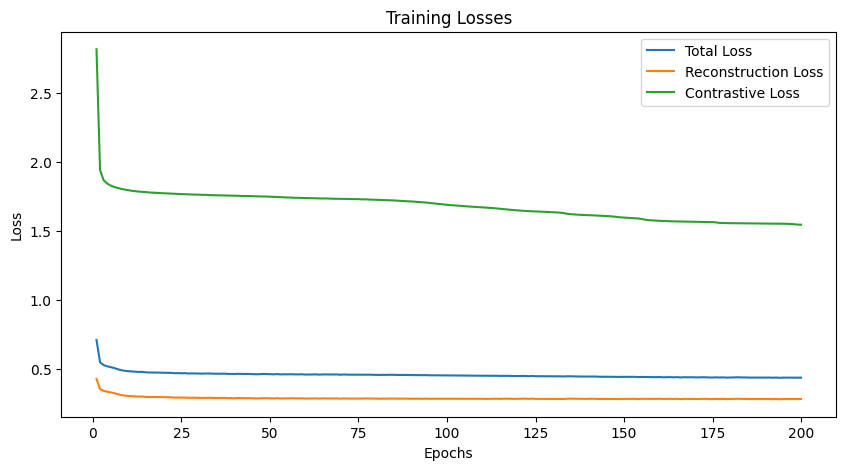

In [32]:
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm

print(device)

def plot_losses(losses):
    epochs = range(1, len(losses['total']) + 1)
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, losses['total'], label='Total Loss')
    plt.plot(epochs, losses['reconstruction'], label='Reconstruction Loss')
    plt.plot(epochs, losses['contrastive'], label='Contrastive Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training Losses')
    plt.show()
    
# Create the dataset
dataset = EHRDataset(preprocessed_data)

batch_size = 32
# Create the patient sampler
patient_sampler = PatientSampler(dataset, batch_size=batch_size)

# Create the dataloader
dataloader = DataLoader(dataset, batch_sampler=patient_sampler, collate_fn=collate_fn)

# Training loop
model = EHRTransformer(num_data_types, d_model, num_heads, num_layers, d_ff, dropout).to(device)

# Assuming you have already defined and initialized your model, optimizer, dataloader, etc.
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

# Training loop
#num_epochs = 2
all_losses = {'total': [], 'reconstruction': [], 'contrastive': []}

for epoch in range(num_epochs):
    epoch_loss, epoch_losses = train_epoch(model, dataloader, optimizer, continuous_features, num_categories, device)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")
    
    all_losses['total'].append(sum(epoch_losses['total']) / len(epoch_losses['total']))
    all_losses['reconstruction'].append(sum(epoch_losses['reconstruction']) / len(epoch_losses['reconstruction']))
    all_losses['contrastive'].append(sum(epoch_losses['contrastive']) / len(epoch_losses['contrastive']))

# Plot losses
plot_losses(all_losses)

KeyError: 1

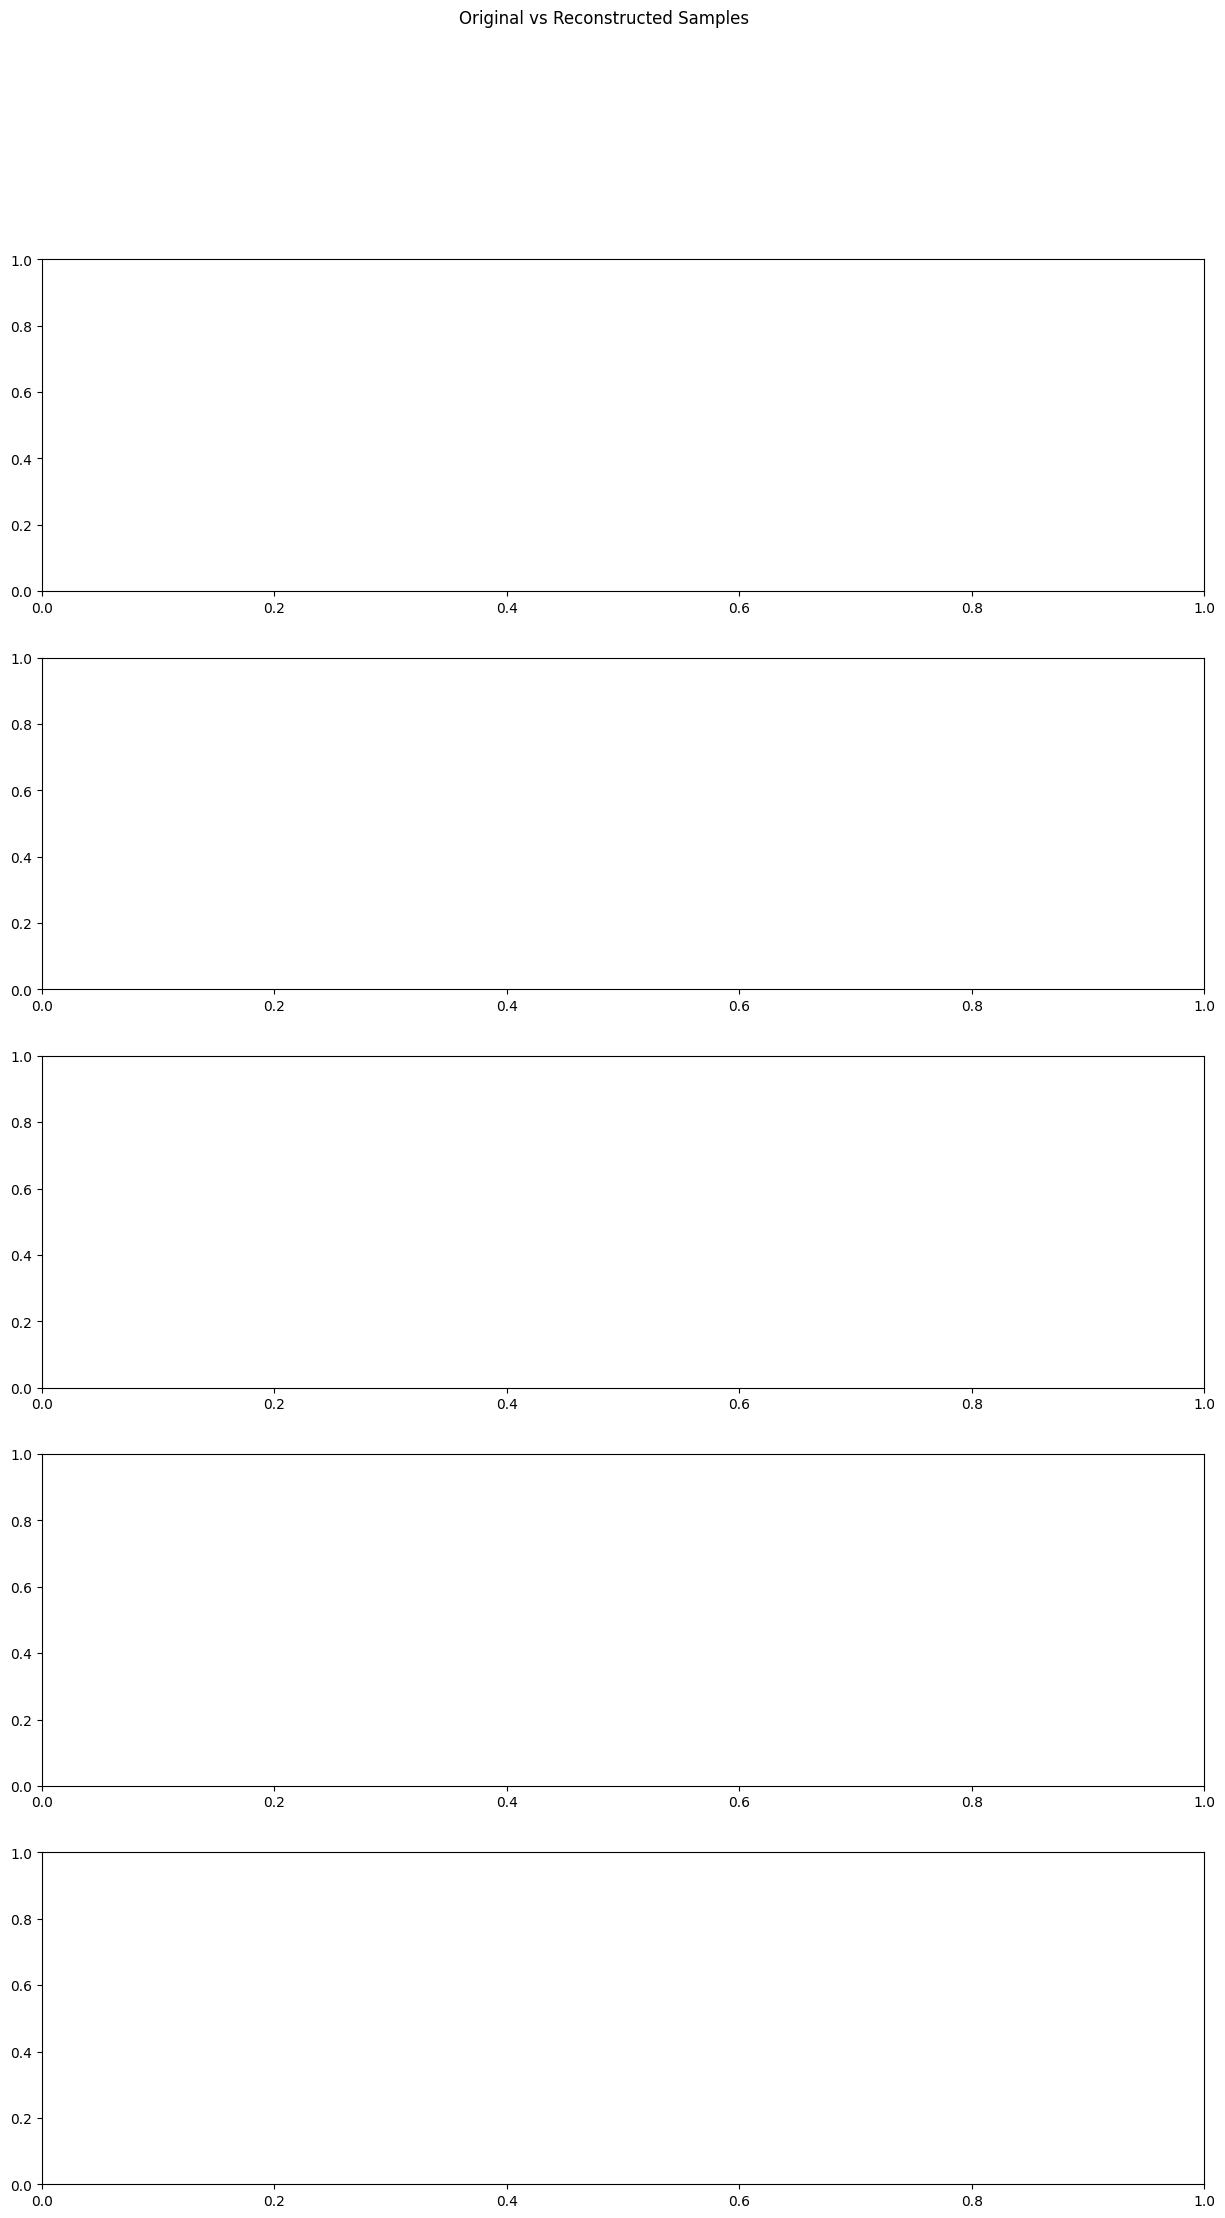

In [37]:
def reconstruct_and_compare_features(model, dataloader, device, value_normalizer, num_samples=5):
    model.eval()
    with torch.no_grad():
        for batch in dataloader:
            batch = {k: v.to(device) for k, v in batch.items() if isinstance(v, torch.Tensor)}
            
            output = model(batch['data_type'], batch['value'], batch['timestamp'], batch['time_diff'], batch['attention_mask'])

            fig, axs = plt.subplots(num_samples, 1, figsize=(15, 5 * num_samples))
            fig.suptitle("Original vs Reconstructed Samples")

            for i in range(num_samples):
                patient_data = {k: v[i] for k, v in batch.items()}
                patient_output = output[i]

                valid_indices = patient_data['attention_mask'].bool()

                timestamps = patient_data['timestamp'][valid_indices].cpu().numpy()
                data_types = patient_data['data_type'][valid_indices].cpu().numpy()
                original_values = patient_data['value'][valid_indices].cpu().numpy()
                reconstructed_values = patient_output[valid_indices, 0].cpu().numpy()

                original_values_unscaled = []
                reconstructed_values_unscaled = []
                for j, data_type_idx in enumerate(data_types):
                    data_type_name = value_normalizer.idx_to_data_type[data_type_idx.item()]
                    original_values_unscaled.append(value_normalizer.inverse_normalize(data_type_name, original_values[j]))
                    reconstructed_values_unscaled.append(value_normalizer.inverse_normalize(data_type_name, reconstructed_values[j]))

                original_values_unscaled = np.array(original_values_unscaled)
                reconstructed_values_unscaled = np.array(reconstructed_values_unscaled)

                sort_idx = np.argsort(timestamps)
                timestamps = timestamps[sort_idx]
                data_types = data_types[sort_idx]
                original_values_unscaled = original_values_unscaled[sort_idx]
                reconstructed_values_unscaled = reconstructed_values_unscaled[sort_idx]

                axs[i].scatter(timestamps, original_values_unscaled, label='Original', marker='o')
                axs[i].scatter(timestamps, reconstructed_values_unscaled, label='Reconstructed', marker='x')
                
                for j, (t, v, dt) in enumerate(zip(timestamps, original_values_unscaled, data_types)):
                    axs[i].annotate(value_normalizer.idx_to_data_type[dt.item()], (t, v), xytext=(5, 5), 
                                    textcoords='offset points', fontsize=8, alpha=0.7)

                axs[i].set_title(f"Sample {i+1}")
                axs[i].set_xlabel("Timestamp")
                axs[i].set_ylabel("Value")
                axs[i].legend()

            plt.tight_layout()
            plt.show()

            break  # Only process one batch
       
reconstruct_and_compare_features(model, dataloader, device, value_normalizer)

In [14]:
print("Value shape:", value.shape)
print("Output shape:", output.shape)

Value shape: torch.Size([40])
Output shape: torch.Size([512, 40, 128])
